In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [35]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings
import seaborn as sns
from scipy.stats.mstats import winsorize

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [4]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'


<IPython.core.display.Javascript object>

In [5]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from useducation',con=engine)
engine.dispose()


<IPython.core.display.Javascript object>

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   PRIMARY_KEY                   1492 non-null   object 
 1   STATE                         1492 non-null   object 
 2   YEAR                          1492 non-null   int64  
 3   ENROLL                        1229 non-null   float64
 4   TOTAL_REVENUE                 1280 non-null   float64
 5   FEDERAL_REVENUE               1280 non-null   float64
 6   STATE_REVENUE                 1280 non-null   float64
 7   LOCAL_REVENUE                 1280 non-null   float64
 8   TOTAL_EXPENDITURE             1280 non-null   float64
 9   INSTRUCTION_EXPENDITURE       1280 non-null   float64
 10  SUPPORT_SERVICES_EXPENDITURE  1280 non-null   float64
 11  OTHER_EXPENDITURE             1229 non-null   float64
 12  CAPITAL_OUTLAY_EXPENDITURE    1280 non-null   float64
 13  GRA

<IPython.core.display.Javascript object>

## Q1 ##
Consider the two variables: TOTAL_REVENUE and TOTAL_EXPENDITURE. Do these variables have outlier values?


In [26]:
# tukey's method:
cols = ["TOTAL_REVENUE", "TOTAL_EXPENDITURE"]
np.percentile(df["TOTAL_REVENUE"], [75, 25])
for col in cols:
    q75, q25 = np.nanpercentile(df[col], [75, 25])
    iqr = q75 - q25
    min_val = q25 - (iqr * 1.5)
    max_val = q75 + (iqr * 1.5)
    print(
        "Number of outliers is: {}".format(
            len((np.where((df[col] > max_val) | (df[col] < min_val))[0]))
        )
    )

Number of outliers is: 110
Number of outliers is: 111


<IPython.core.display.Javascript object>

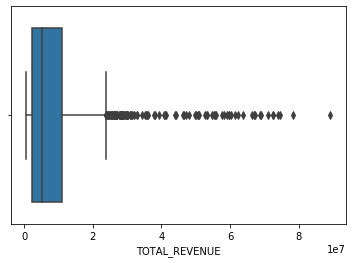

<IPython.core.display.Javascript object>

In [29]:
sns.boxplot(x=df["TOTAL_REVENUE"])


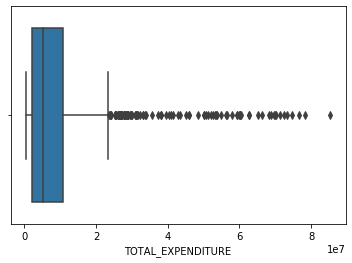

<IPython.core.display.Javascript object>

In [30]:
sns.boxplot(x=df["TOTAL_EXPENDITURE"])

In [31]:
outliers = np.where((df[col] > max_val) | (df[col] < min_val))

<IPython.core.display.Javascript object>

In [34]:
df.iloc[outliers].STATE.value_counts()

NEW_YORK        24
CALIFORNIA      24
TEXAS           20
FLORIDA         12
NEW_JERSEY      11
PENNSYLVANIA    11
ILLINOIS         9
Name: STATE, dtype: int64

<IPython.core.display.Javascript object>

It seems like the outliers are just data from the larger states, so I don't think you should delete them at all, but in the interest of doing the exercise I'll windsorize them.

In [36]:
w_rev = winsorize(df["TOTAL_REVENUE"], (0, 0.05))
w_exp = winsorize(df["TOTAL_EXPENDITURE"], (0, 0.05))


<IPython.core.display.Javascript object>

### Q3 ###
Create another variable by subtracting the original TOTAL_EXPENDITURE from TOTAL_REVENUE (before you eliminated the outliers). You can think of it as a kind of budget deficit in education. Do you find any outlier values in this new variable? If so, eliminate them using the technique you think most suitable.


In [69]:
df["SURPLUS"] = df["TOTAL_REVENUE"] - df["TOTAL_EXPENDITURE"]

<IPython.core.display.Javascript object>

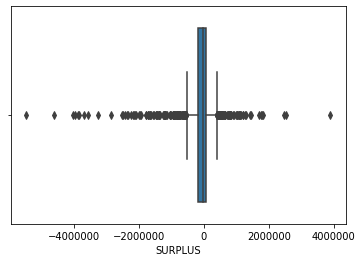

<IPython.core.display.Javascript object>

In [64]:
sns.boxplot(x=df["SURPLUS"])

In [65]:
q75_2, q25_2 = np.nanpercentile(df["SURPLUS"], [75, 25])
iqr2 = q75_2 - q25_2
min_val2 = q25_2 - (iqr2 * 1.5)
max_val2 = q75_2 + (iqr2 * 1.5)
print(
    "Number of outliers is: {}".format(
        len((np.where((df["SURPLUS"] > max_val2) | (df["SURPLUS"] < min_val2))[0]))
    )
)

Number of outliers is: 198


<IPython.core.display.Javascript object>

Again, I don't think these should be dropped or changed really because they are important info. But I'll drop them since I windsorized the previous ones. What we should do is treat the data on a per student basis

In [71]:
# outliers2 = np.where((df["SURPLUS"] > max_val2) | (df["SURPLUS"] < min_val2))
df = df[(df["SURPLUS"] < max_val2) & (df["SURPLUS"] > min_val2)]

<IPython.core.display.Javascript object>

In [72]:
df["SURPLUS"]

0        25087.0
1        77103.0
2      -143501.0
3       -31063.0
5       -79653.0
          ...   
1278    108637.0
1279     25695.0
1280    347190.0
1281     35672.0
1284   -174881.0
Name: SURPLUS, Length: 1082, dtype: float64

<IPython.core.display.Javascript object>

## 4 ##

Now create another variable by subtracting the TOTAL_EXPENDITURE from TOTAL_REVENUE. This time, use the outlier eliminated versions of TOTAL_EXPENDITURE from TOTAL_REVENUE. In this newly created variable, can you find any outliers? If so, eliminate them.


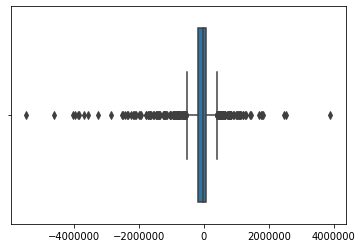

<IPython.core.display.Javascript object>

In [78]:
surplus2 = w_rev - w_exp
sns.boxplot(x=surplus2)

In [79]:
w_surplus2 = winsorize(surplus2, (0, 0.10))

<IPython.core.display.Javascript object>

## 5 ##
Compare some basic descriptive statistics of the budget variables you end up with in the 3rd and the 4th questions. Do you see any differences?


In [85]:
# pd.DataFrame(
#     {"dropped_surplus": df["SURPLUS"], "winsorized_surplus": w_surplus2}
# ).describe()
df[["SURPLUS"]].describe()

,SURPLUS
count,1082.000000
mean,-43762.679298
std,167828.760582
min,-530721.000000
25%,-126957.250000
50%,-17248.000000
75%,35846.250000
max,395673.000000


<IPython.core.display.Javascript object>

In [84]:
pd.DataFrame(w_surplus2).describe()

,0
count,1.280000e+03
mean,-1.045990e+05
std,5.734045e+05
min,-5.487742e+06
25%,-1.816858e+05
50%,-2.148400e+04
75%,5.130425e+04
max,3.897129e+06


<IPython.core.display.Javascript object>

They're extremely different. The mean of the second is half that of the first, and the std a third of the size

## 6 ##

If our variable of interest is the budget deficit variable, which method do you think is the appropriate in dealing with the outliers in this variable: the method in the 3rd question or the one in the 4th question?

The last method would probably be better. You're eliminating outliers in one of the dimensions (revenue or expenditure), so this is going to be more sensitive to false data inputs (since they operate on a single datapoint-basis). Really, I think you should be very strict with eliminating outliers here, since you're basically just eliminating states that are  big or small, or are good or bad at "balancing" budgets (depending on the method you choose). You should be looking at the data on a per-pupil basis, which would eliminate many of the outliers by itself. 